# Hotdog or not Hotdog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Disable all GPUS, but using this model with Conv2D, is faster with GPU
# tf.config.set_visible_devices([], 'GPU')

/Users/silvio/miniforge3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [16]:
train_ds, valid_ds = ds['train'], ds['validation']

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


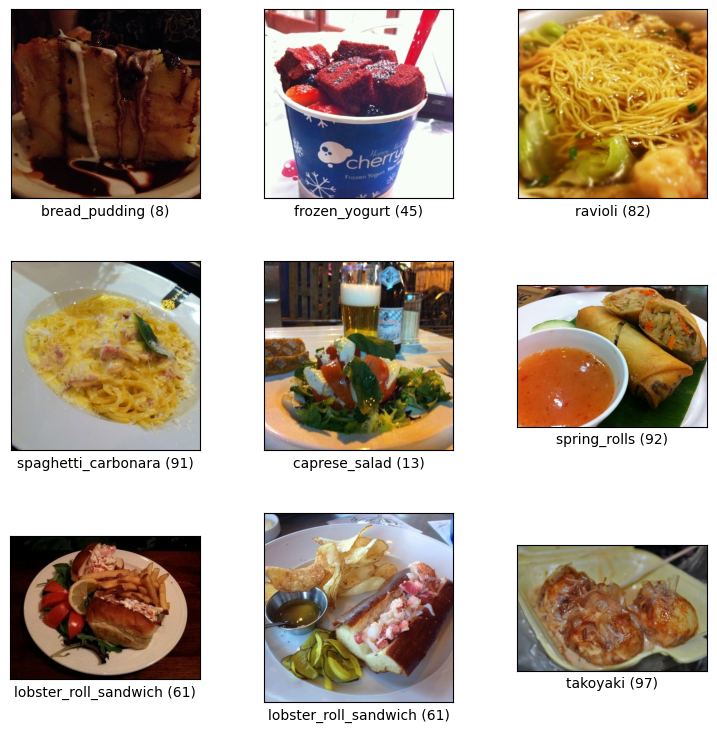

In [5]:
fig = tfds.show_examples(ds_info, train_ds)

In [17]:
MAX_SIDE_LEN = 128
HOTDOG_CLASS = 55

train_ds = train_ds.map(
    lambda img, label: (
        tf.cast(tf.image.resize(img, (MAX_SIDE_LEN, MAX_SIDE_LEN)), dtype=tf.int32), 
        tf.cast(label == HOTDOG_CLASS, dtype=tf.int32)
    )
)

valid_ds = valid_ds.map(
    lambda img, label: (
        tf.cast(tf.image.resize(img, (MAX_SIDE_LEN, MAX_SIDE_LEN)), dtype=tf.int32), 
        tf.cast(label == HOTDOG_CLASS, dtype=tf.int32)
    )
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


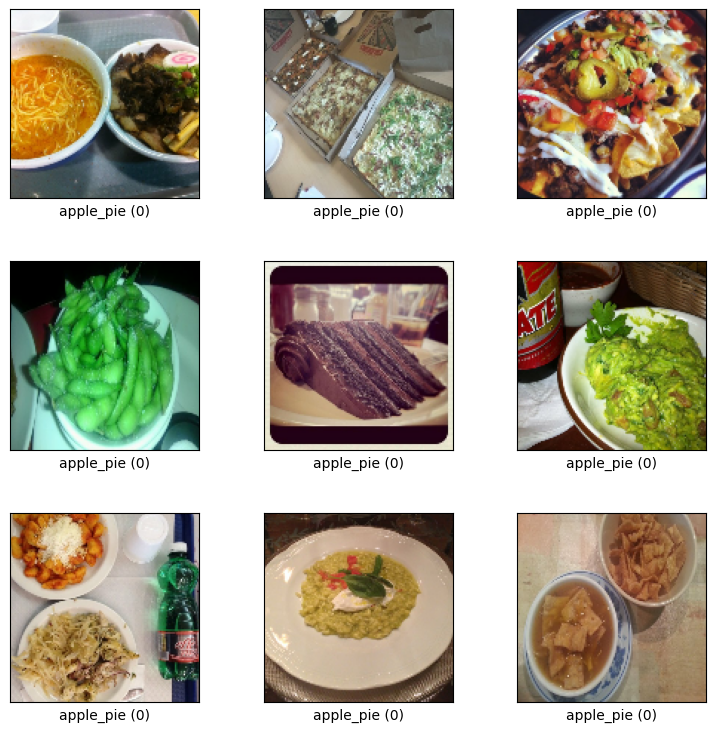

In [28]:
fig = tfds.show_examples(ds_info, train_ds)

In [31]:
# reshape the dataset to have about the same hotdog images as not hotdog images

train_hd_sizem, valid_hd_size = 750, 250

train_hotdogs = train_ds.filter(lambda img, label: label == 1).repeat(3)
train_not_hotdogs = train_ds.filter(lambda img, label: label == 0)

valid_hotdogs = valid_ds.filter(lambda img, label: label == 1).repeat(3)
valid_not_hotdogs = valid_ds.filter(lambda img, label: label == 0)

In [33]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_not_hotdogs], [0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_not_hotdogs], [0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [34]:
# checking the dataset batch
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(16, 128, 128, 3)
(16,)


2023-07-11 09:24:18.664944: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Neuro Net implementation

In [41]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

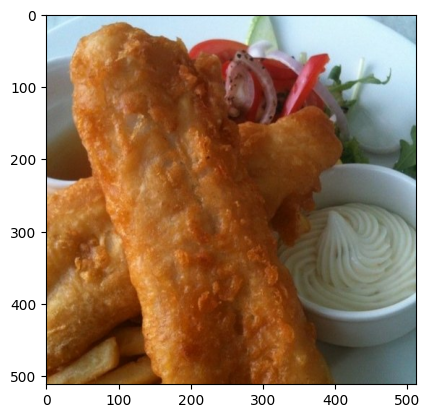

In [46]:
for i, _ in ds["train"].take(1):
    image = i

plt.imshow(image)

image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

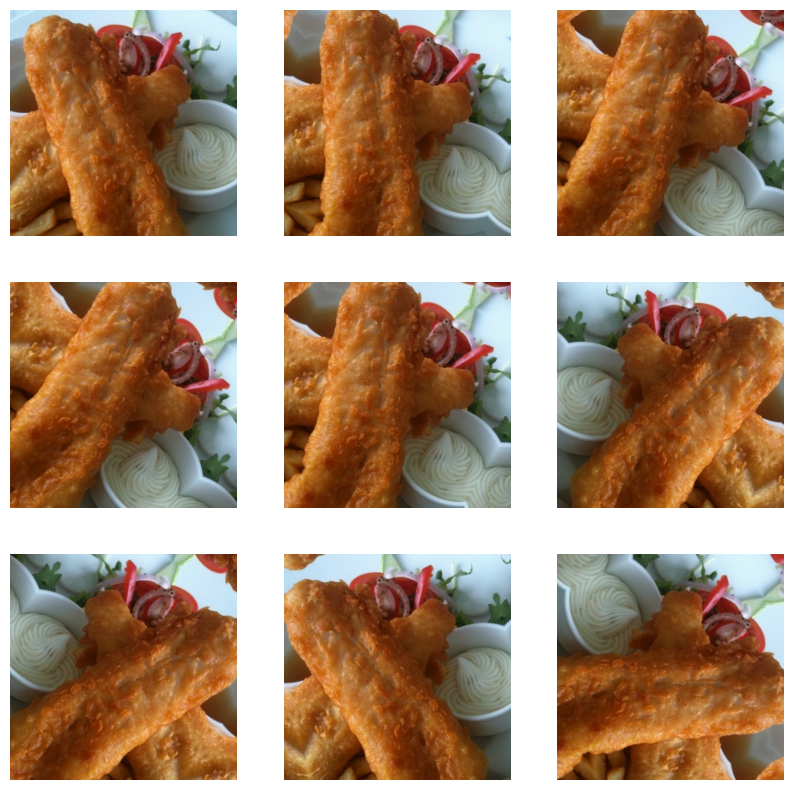

In [47]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [55]:
random.seed(0)

model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [56]:
lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [57]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
284/284 [==============================] - 15s 47ms/step - loss: 1.4233 - accuracy: 0.5059 - val_loss: 1.1479 - val_accuracy: 0.4870
Epoch 2/50
284/284 [==============================] - 13s 44ms/step - loss: 0.9903 - accuracy: 0.5048 - val_loss: 0.8761 - val_accuracy: 0.4870
Epoch 3/50
284/284 [==============================] - 13s 44ms/step - loss: 0.8105 - accuracy: 0.5194 - val_loss: 0.7680 - val_accuracy: 0.4904
Epoch 4/50
284/284 [==============================] - 13s 45ms/step - loss: 0.7404 - accuracy: 0.5458 - val_loss: 0.7255 - val_accuracy: 0.4904
Epoch 5/50
284/284 [==============================] - 14s 48ms/step - loss: 0.7086 - accuracy: 0.5572 - val_loss: 0.7032 - val_accuracy: 0.5123
Epoch 6/50
284/284 [==============================] - 13s 44ms/step - loss: 0.6939 - accuracy: 0.5625 - val_loss: 0.6908 - val_accuracy: 0.5301
Epoch 7/50
284/284 [==============================] - 13s 45ms/step - loss: 0.6779 - accuracy: 0.5799 - val_loss: 0.6774 - val_accuracy:

In [58]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

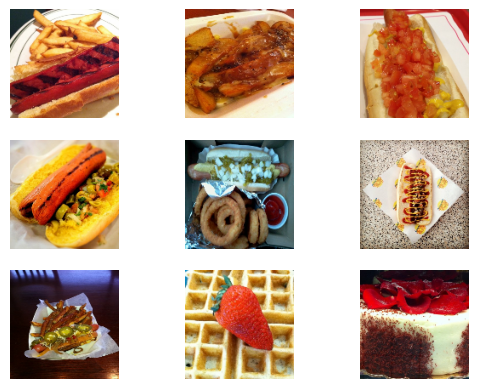

In [59]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [60]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int32)>